# Домашнее задание по теме "Гибридные рекомендательные системы"

**Цель работы:**  
написать свою гибридную рекомендательную систему


**Задачи работы:**  
1. ***Построить рекомендации на фичах:***
        - TF-IDF на тегах и жанрах  
             
             
2. ***Построить гибридную рекомендательную систему***

**План работы:**
1. Выгрузить и проанализировать данные  
2. Сделать TF-IDF-преобразование и собрать датасет  
3. Обучить модели
4. Сделать выводы

Итак, чтобы не делать двойную работу, возьмем предобработанный датасет из домашней работы №1:

### 1. Предобработка данных и EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import datetime
import warnings
from tabulate import tabulate
from scipy import stats
warnings.filterwarnings("ignore")

In [2]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

In [3]:
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

Теперь напишем функцию, которая на выходе будет показывать основную информацию о файлах: их размер, статистику, количество пропусков, info файла, графики взаимозависимостей признаков и первые 5 строк файла:

In [5]:
def info(data):
    shape = data.shape
    isna = data.isna().sum()
    desc = data.describe()
    head = data.head()
    print('\033[1m' + 'data shape: ' + '\033[0m', shape, ' \n')
    print('\033[1m' +  'data describe: ' + '\033[0m', '\n ', desc, ' \n')
    print('\033[1m' +  'data isna: ' + '\033[0m', '\n ', isna, ' \n') 
    print('\033[1m' +  'data info: ' + '\033[0m')
    info = data.info()
    print()
    sns.pairplot(data)
    plt.show()
    print('\033[1m' +  'data head: ' + '\033[0m')
    return head

<u/>Начнем с links:</u>

data shape:  (9742, 3)  

data describe:  
               movieId        imdbId         tmdbId
count    9742.000000  9.742000e+03    9734.000000
mean    42200.353623  6.771839e+05   55162.123793
std     52160.494854  1.107228e+06   93653.481487
min         1.000000  4.170000e+02       2.000000
25%      3248.250000  9.518075e+04    9665.500000
50%      7300.000000  1.672605e+05   16529.000000
75%     76232.000000  8.055685e+05   44205.750000
max    193609.000000  8.391976e+06  525662.000000  

data isna:  
  movieId    0
imdbId     0
tmdbId     8
dtype: int64  

data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB



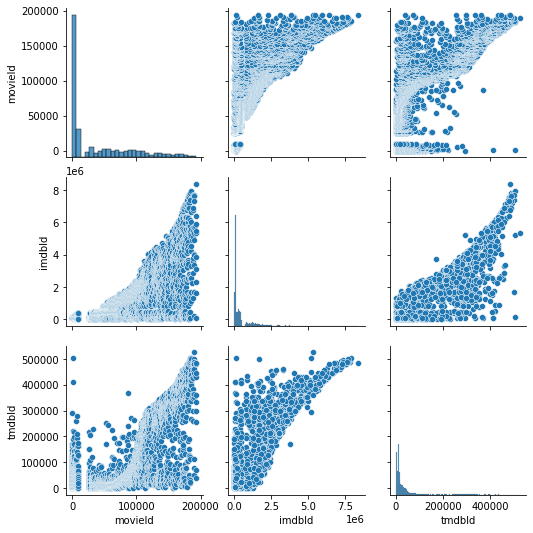

data head: 


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
info(links)

Сразу бросается в глаза наличие 8 пропусков в столбце "tmdbId". Стоит ли нам их заполнять? В идеале - стоит, однако ответим на вопрос, что содержит в себе эта таблица? Это просто уникальные id фильмов и их же id на популярных сайтах imdb и tmdb.  
Помогут ли они в предсказании оптимального фильма для рекомендации? Вряд ли. По сути это индексы. "Отложим" эту таблицу и перейдем к следующей.

<u/>movies:</u>

data shape:  (9742, 3)  

data describe:  
               movieId
count    9742.000000
mean    42200.353623
std     52160.494854
min         1.000000
25%      3248.250000
50%      7300.000000
75%     76232.000000
max    193609.000000  

data isna:  
  movieId    0
title      0
genres     0
dtype: int64  

data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB



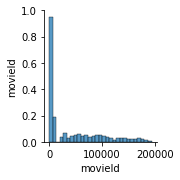

data head: 


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
info(movies)

Это нужный файл. С ним поработаем отдельно. Как мы видим, 2 столбца из 3-х имеют тип данных object. Именно их нужно будет преобразовать. Также стоит отметить, что большая часть id сосредоточена ближе к нулю (см. гистограммму). Количество строк совпадает с файлом links.

<u/>ratings:</u>

data shape:  (100836, 4)  

data describe:  
                userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09  

data isna:  
  userId       0
movieId      0
rating       0
timestamp    0
dtype: int64  

data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-nu

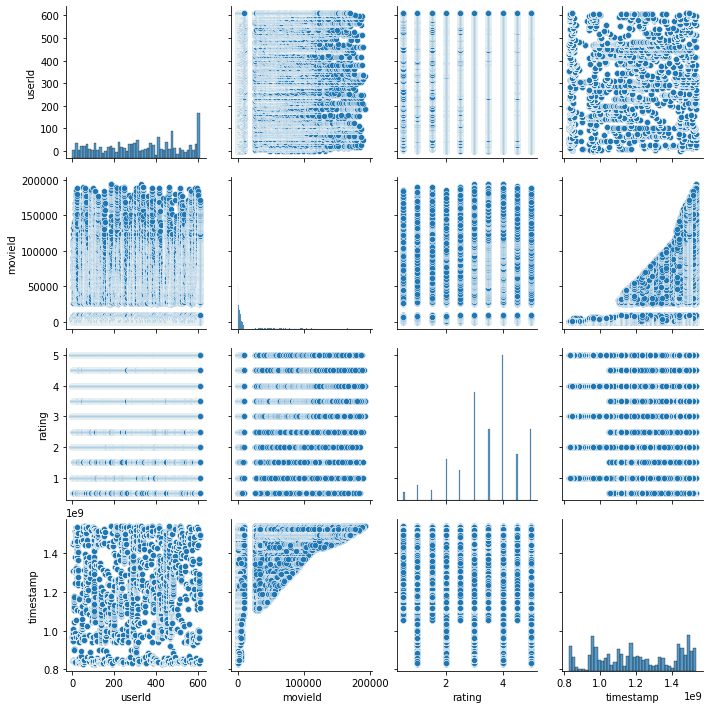

data head: 


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
info(ratings)

In [9]:
date = [datetime.datetime.fromtimestamp(ratings['timestamp'][i]).date() for i in range(len(ratings['timestamp']))]

Пропусков нет, и это хорошо. ID, что представлены здесь, нам понадобятся. Рейтинг - одна из самых нужных фичей. Насколько важен столбец со временем - посмотрим в перспективе.  

Коротко о столбцах рейтинга и времени:  
timestamp. Мы видим на диаграмме, что время представлено скачкообразно. Посмотрим поближе:

In [10]:
date = [datetime.datetime.fromtimestamp(ratings['timestamp'][i]).date() for i in range(len(ratings['timestamp']))]

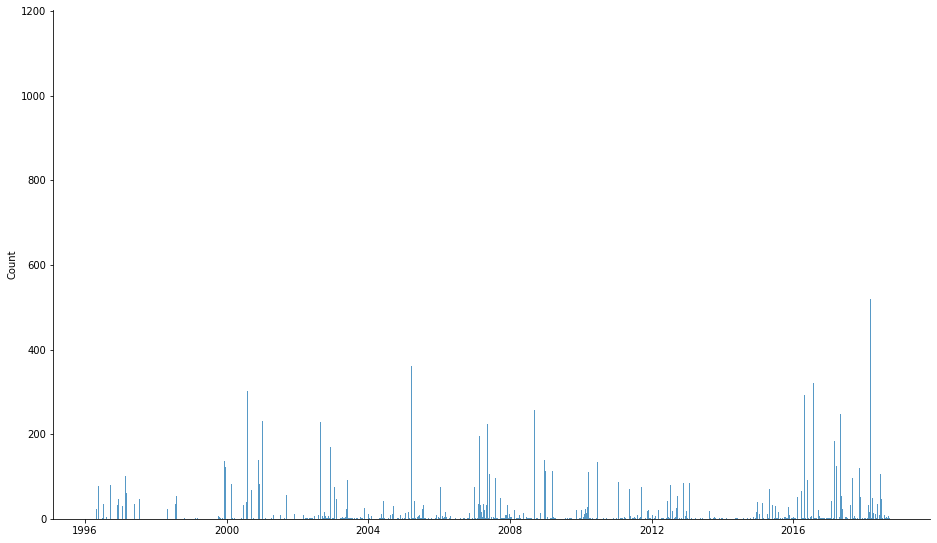

In [11]:
g=sns.displot(date)
g.fig.set_size_inches(15,8)

Пока можно сказать только, что оценок после 2016 года стало намного больше. Разобьем по годам и посмотрим предметнее:

In [12]:
date[0].year

2000

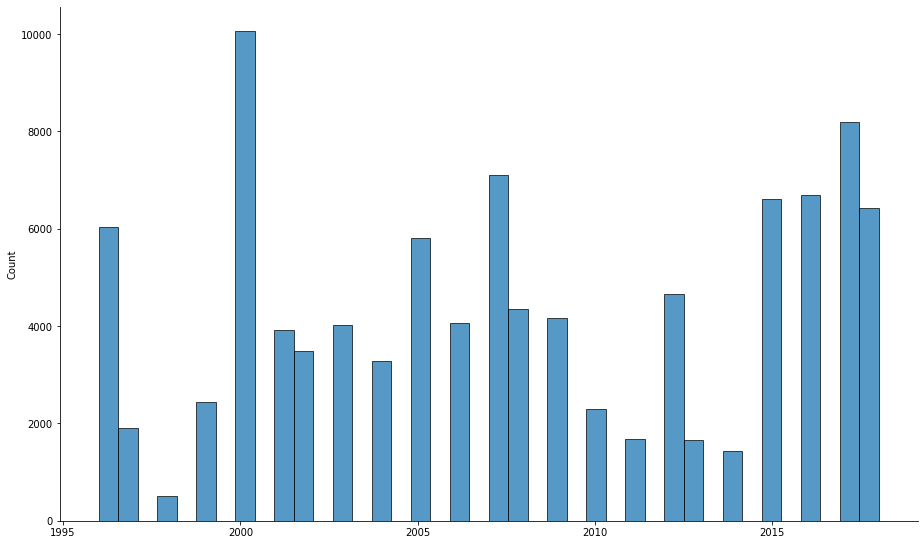

In [13]:
g=sns.displot([i.year for i in date])
g.fig.set_size_inches(15,8)

А вот и нет. Получается, 2000 год был более плодотворный на отзывы. А какой месяц является самым активным за весь период?

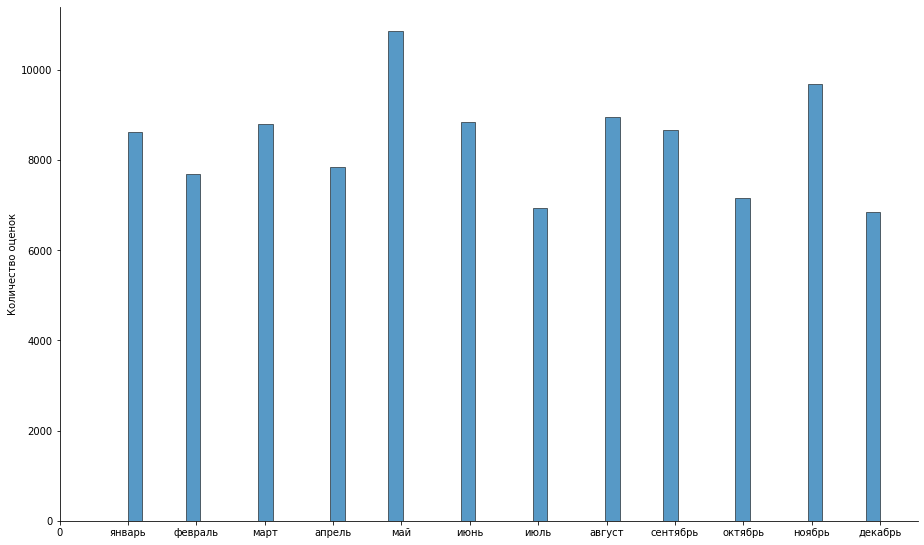

In [14]:
g=sns.displot([m.month for m in date])
plt.xticks(range(13), [0, 'январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 
                   'сентябрь', 'октябрь', 'ноябрь', 'декабрь'])
plt.ylabel('Количество оценок')
g.fig.set_size_inches(15,8)

Больше всего оценок в мае. Далее - ноябрь. Вероятно, это самое популярное время премьер кинофильмов.  

Посмортим поближе на 2000 год: какой месяц был здесь самым активным?

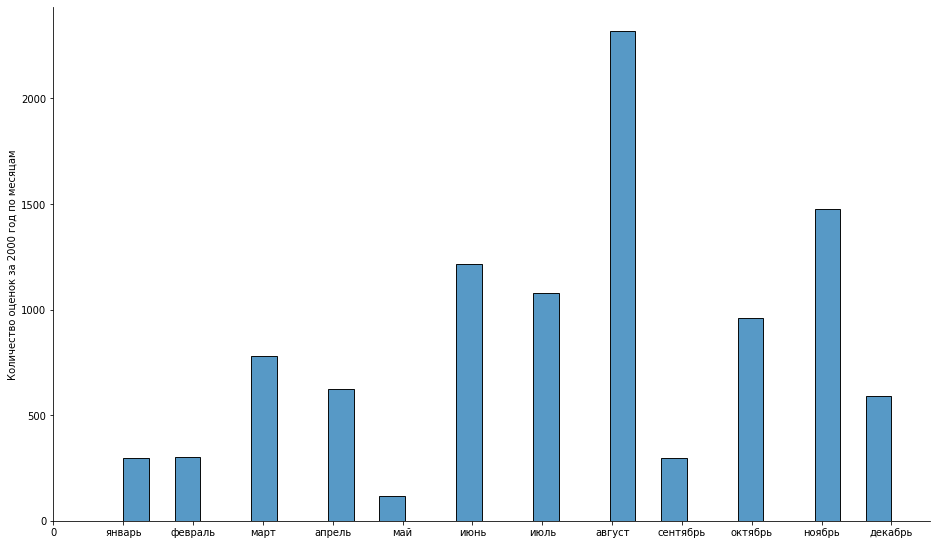

In [15]:
year_2000 = [i for i in date if i.year == 2000]

g=sns.displot([m.month for m in year_2000])
plt.xticks(range(13), [0, 'январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 
                   'сентябрь', 'октябрь', 'ноябрь', 'декабрь'])
plt.ylabel('Количество оценок за 2000 год по месяцам')
g.fig.set_size_inches(15,8)

Картина несколько изменилась: теперь в фаворе август. Остальные месяцы сильно отстают.  
    
Посмотрим теперь на дни месяца:

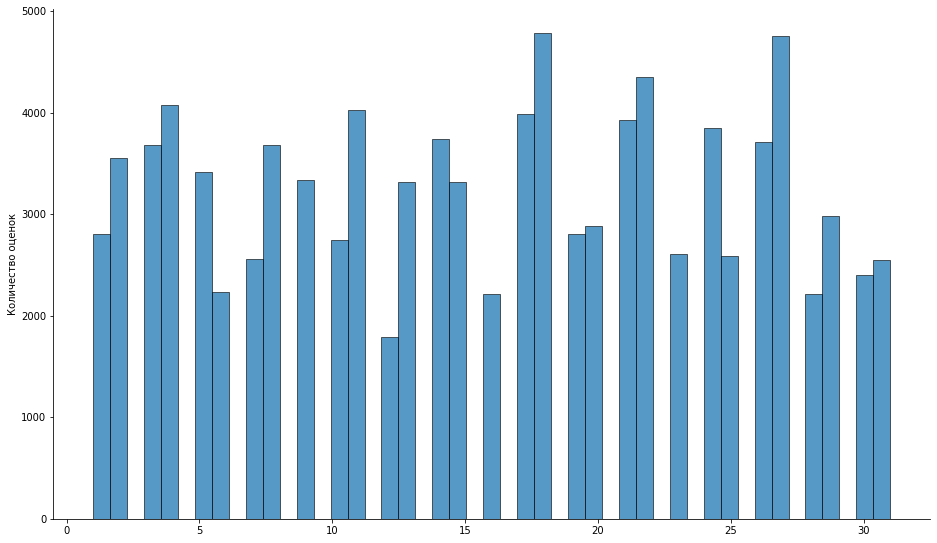

In [16]:
g=sns.displot([d.day for d in date])
plt.ylabel('Количество оценок')
g.fig.set_size_inches(15,8)

Любопытное наблюдение: во вторую половину месяца, как правило, голосуют чаще.

Теперь интересно взглянуть на дни недели по всей истории выставления оценок:

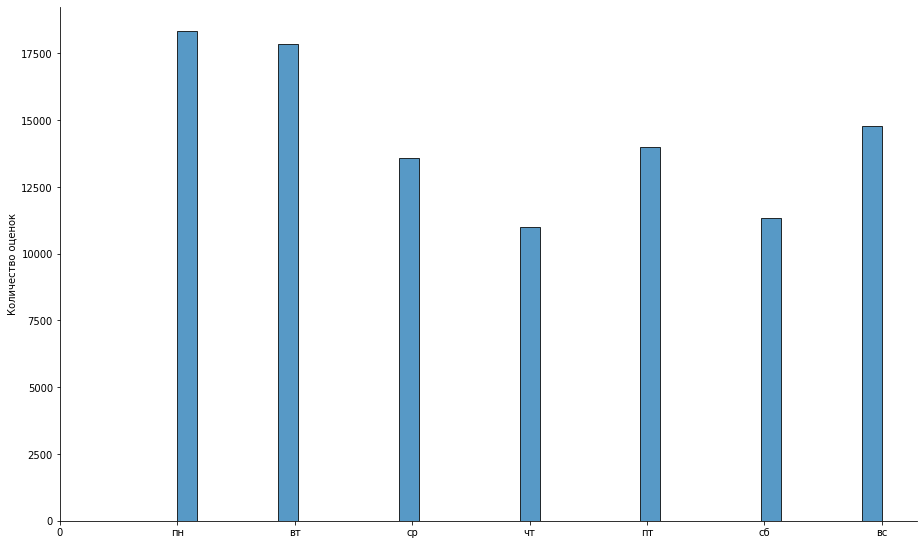

In [17]:
g=sns.displot([w.isoweekday() for w in date])
plt.xticks(range(8), [0, 'пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])
plt.ylabel('Количество оценок')
g.fig.set_size_inches(15,8)

В целом в понедельник оценивали несколько чаще, чем в другие дни. Вероятно, отзыв писался (и оценка ставилась) на работе после посещения кинопремьеры в выходной))

Ок. Переходим к последнему столбцу - rating. Здесь не так много уникальных значений (судя по информации из describe).  
Посмотрим на график и посчитаем количество оценок:

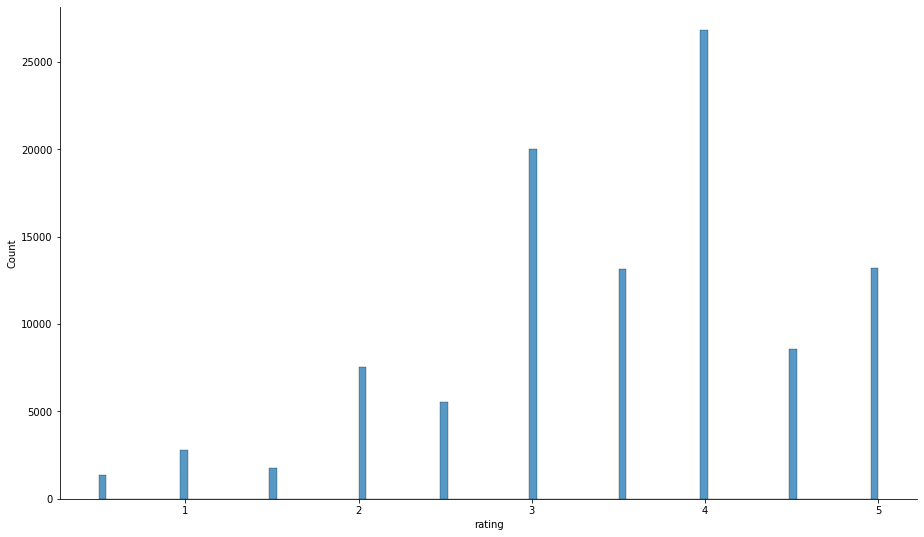

In [18]:
g=sns.displot(ratings['rating'])
g.fig.set_size_inches(15,8)

In [19]:
ratings['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

Самая частая оценка - 4.0. Вполне логично.

А какие оценки любят ставить в разные месяцы?

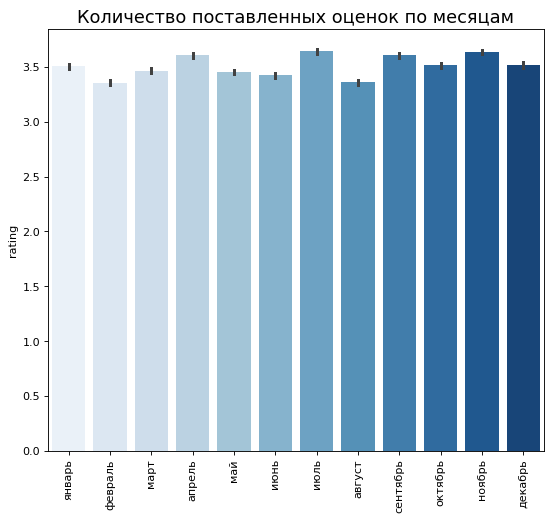

In [20]:
plt.figure(figsize=(8, 7), dpi=80)
sns.barplot(x=[m.month for m in date], y='rating', data=ratings, palette="Blues")
plt.title('Количество поставленных оценок по месяцам', fontsize=16)
plt.xticks(range(12), ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 
                   'сентябрь', 'октябрь', 'ноябрь', 'декабрь'])
plt.xticks(rotation=90)
plt.show()

И снова видно, что в апреле, июле и ноябре несколько больше отзывов, чем в другие месяцы.  
Идем дальше.

In [21]:
del date

<u/>tags:</u>

data shape:  (3683, 4)  

data describe:  
              userId        movieId     timestamp
count  3683.000000    3683.000000  3.683000e+03
mean    431.149335   27252.013576  1.320032e+09
std     158.472553   43490.558803  1.721025e+08
min       2.000000       1.000000  1.137179e+09
25%     424.000000    1262.500000  1.137521e+09
50%     474.000000    4454.000000  1.269833e+09
75%     477.000000   39263.000000  1.498457e+09
max     610.000000  193565.000000  1.537099e+09  

data isna:  
  userId       0
movieId      0
tag          0
timestamp    0
dtype: int64  

data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB



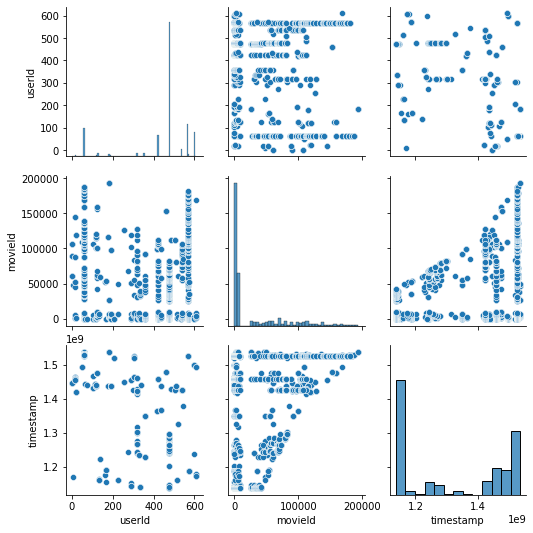

data head: 


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [22]:
info(tags)

И снова тут есть столбец "timestamp". Циклом пройдемся по нему и нагенерим признаков для тегов:

In [23]:
date = [datetime.datetime.fromtimestamp(tags['timestamp'][i]).date() for i in range(len(tags['timestamp']))]
date[-5:]

[datetime.date(2007, 2, 12),
 datetime.date(2007, 3, 9),
 datetime.date(2017, 5, 3),
 datetime.date(2017, 5, 3),
 datetime.date(2017, 5, 3)]

In [24]:
tags['year_tags'] = [i.year for i in date]
tags['month_tags'] = [i.month for i in date]
tags['day_tags'] = [i.day for i in date]
tags['day_of_week_tags'] = [i.isoweekday() for i in date]

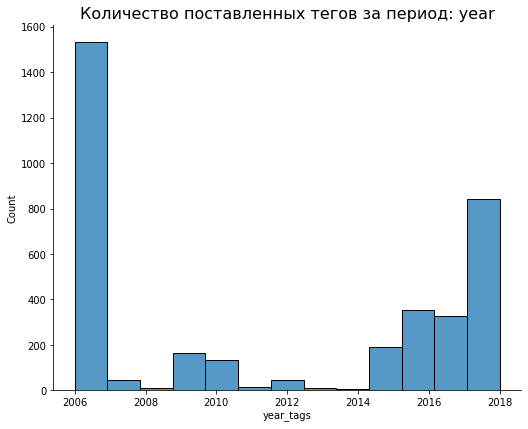

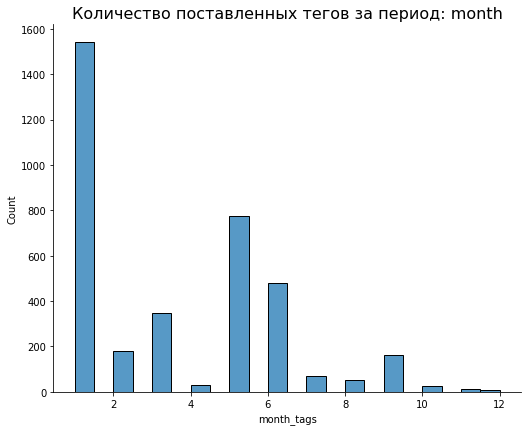

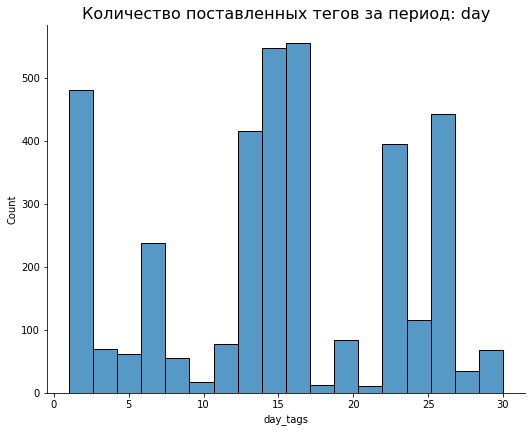

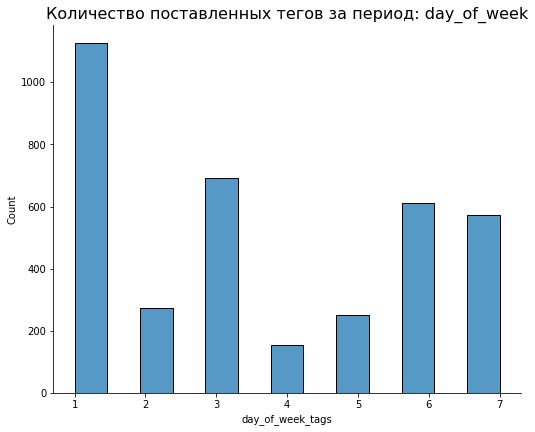

In [25]:
date_list = ['year_tags', 'month_tags', 'day_tags', 'day_of_week_tags']
for i in date_list:
    g=sns.displot(tags[i])
    plt.title('Количество поставленных тегов за период: {}'.format(i[:-5]), fontsize=16)
    g.fig.set_size_inches(8,6)
    plt.show()

In [26]:
del date

Итак, больше всего тегов проставлено в 2006 году; если рассматривать месяцы - в январе; если рассматривать дни месяца - то, как и при выставлении рейтинга, активнее вторая половина месяца (точнее середина и далее); и если говорить о днях недели, то чаще всего тэги ставят тоже в понедельник. Получается, данные перекликаются, т.е. закономерности действительно присутствуют.

### 2. Объединение фреймов в один и работа с TF-IDF

In [27]:
tags.shape, movies.shape, ratings.shape

((3683, 8), (9742, 3), (100836, 4))

Поскольку именно таблица с названиями фильмов является приоритетной, то присоединять другие таблицы будем именно к ней. Поэтому будем считать, что количество строк, равное 9742, - эталон.  
Работаем с таблицей ratings. Сначала сгруппируем данные по столбцу movieId:

In [28]:
new_ratings = ratings.groupby('movieId')['rating'].agg([np.mean, np.median, np.var, np.count_nonzero])
new_ratings = new_ratings.reset_index()
new_ratings.head()

,movieId,mean,median,var,count_nonzero
0,1,3.920930,4.0,0.696990,215.0
1,2,3.431818,3.5,0.777419,110.0
2,3,3.259615,3.0,1.112651,52.0
3,4,2.357143,3.0,0.726190,7.0
4,5,3.071429,3.0,0.822917,49.0


In [29]:
new_ratings.tail()

,movieId,mean,median,var,count_nonzero
9719,193581,4.0,4.0,NaN,1.0
9720,193583,3.5,3.5,NaN,1.0
9721,193585,3.5,3.5,NaN,1.0
9722,193587,3.5,3.5,NaN,1.0
9723,193609,4.0,4.0,NaN,1.0


проверка:

In [30]:
ratings[ratings['movieId'] == 193609]

,userId,movieId,rating,timestamp
51362,331,193609,4.0,1537157606


In [31]:
new_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9724 entries, 0 to 9723
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        9724 non-null   int64  
 1   mean           9724 non-null   float64
 2   median         9724 non-null   float64
 3   var            6278 non-null   float64
 4   count_nonzero  9724 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 380.0 KB


Идем дальше. Сравним размер таблицы new_ratings с movies:

In [32]:
movies.shape

(9742, 3)

У 18 фильмов нет рейтинга. Что за фильмы?

In [33]:
without_rating = set(movies['movieId'].tolist()) - set(new_ratings['movieId'].tolist())
without_rating

{1076,
 2939,
 3338,
 3456,
 4194,
 5721,
 6668,
 6849,
 7020,
 7792,
 8765,
 25855,
 26085,
 30892,
 32160,
 32371,
 34482,
 85565}

In [34]:
movies.query('movieId in @without_rating')

,movieId,title,genres
816,1076,"Innocents, The (1961)",Drama|Horror|Thriller
2211,2939,Niagara (1953),Drama|Thriller
2499,3338,For All Mankind (1989),Documentary
2587,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama
3118,4194,I Know Where I'm Going! (1945),Drama|Romance|War
4037,5721,"Chosen, The (1981)",Drama
4506,6668,"Road Home, The (Wo de fu qin mu qin) (1999)",Drama|Romance
4598,6849,Scrooge (1970),Drama|Fantasy|Musical
4704,7020,Proof (1991),Comedy|Drama|Romance
5020,7792,"Parallax View, The (1974)",Thriller


Запомним их. После перепроверим.

Объединяем таблицы по movieId:

In [35]:
new_movies = movies.merge(new_ratings, on='movieId', how='left')
new_movies

,movieId,title,genres,mean,median,var,count_nonzero
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,4.0,0.696990,215.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.431818,3.5,0.777419,110.0
2,3,Grumpier Old Men (1995),Comedy|Romance,3.259615,3.0,1.112651,52.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.357143,3.0,0.726190,7.0
4,5,Father of the Bride Part II (1995),Comedy,3.071429,3.0,0.822917,49.0
...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,4.000000,4.0,NaN,1.0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,3.500000,3.5,NaN,1.0
9739,193585,Flint (2017),Drama,3.500000,3.5,NaN,1.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,3.500000,3.5,NaN,1.0


Перепроверим себя:

In [36]:
new_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 0 to 9741
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        9742 non-null   int64  
 1   title          9742 non-null   object 
 2   genres         9742 non-null   object 
 3   mean           9724 non-null   float64
 4   median         9724 non-null   float64
 5   var            6278 non-null   float64
 6   count_nonzero  9724 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 608.9+ KB


Вернемся к пропускам. Обратим внимание на то, что в столбце с дисперсией больше всего пропусков. Это логично, т.к. какая может быть дисперсия, если оценка только одна? Такие строчки будут малоинформативны, поэтому еще раз посмотрим на них (перепроверим себя) и чуть позже всем скопом удалим строки с пропусками:

In [37]:
new_ratings[new_ratings['var'].isna()]   # проверка, когда дисперсия не посчиталась

,movieId,mean,median,var,count_nonzero
45,49,3.0,3.0,NaN,1.0
50,55,4.0,4.0,NaN,1.0
69,77,4.0,4.0,NaN,1.0
75,83,3.0,3.0,NaN,1.0
85,96,3.5,3.5,NaN,1.0
...,...,...,...,...,...
9719,193581,4.0,4.0,NaN,1.0
9720,193583,3.5,3.5,NaN,1.0
9721,193585,3.5,3.5,NaN,1.0
9722,193587,3.5,3.5,NaN,1.0


Идем дальше: сгруппируем таблицу tags по "movieId":

In [38]:
tags['tag'] = tags['tag'] + ' '

new_tags = tags.groupby('movieId')['tag'].sum(", ")
new_tags = new_tags.reset_index()
new_tags.head()

,movieId,tag
0,1,pixar pixar fun
1,2,fantasy magic board game Robin Williams game
2,3,moldy old
3,5,pregnancy remake
4,7,remake


Теперь объединим таблицы new_movies и new_tags:

In [39]:
new_movies = new_movies.merge(new_tags, on='movieId', how='left')
new_movies

,movieId,title,genres,mean,median,var,count_nonzero,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,4.0,0.696990,215.0,pixar pixar fun
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.431818,3.5,0.777419,110.0,fantasy magic board game Robin Williams game
2,3,Grumpier Old Men (1995),Comedy|Romance,3.259615,3.0,1.112651,52.0,moldy old
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.357143,3.0,0.726190,7.0,NaN
4,5,Father of the Bride Part II (1995),Comedy,3.071429,3.0,0.822917,49.0,pregnancy remake
...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,4.000000,4.0,NaN,1.0,NaN
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,3.500000,3.5,NaN,1.0,NaN
9739,193585,Flint (2017),Drama,3.500000,3.5,NaN,1.0,NaN
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,3.500000,3.5,NaN,1.0,NaN


Теперь все нужные нам таблицы собраны. Возвращаемся к пропускам:

In [40]:
new_movies.isna().sum()

movieId             0
title               0
genres              0
mean               18
median             18
var              3464
count_nonzero      18
tag              8170
dtype: int64

Столько тэгов удалить мы не можем. Зато можем заменить пропуски на словосочетание "no tag". Так и поступим:

In [41]:
new_movies['tag'] = new_movies['tag'].fillna('no tag')

Остальные фильмы не оценивались в принципе. Удfлим их, т.к. нашей задаче не помогут:

In [42]:
new_movies = new_movies.dropna(axis=0)
new_movies = new_movies.reset_index(drop=True)

In [43]:
new_movies.isna().sum()

movieId          0
title            0
genres           0
mean             0
median           0
var              0
count_nonzero    0
tag              0
dtype: int64

Что у нас получилось?

In [44]:
new_movies.head()

,movieId,title,genres,mean,median,var,count_nonzero,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,4.0,0.696990,215.0,pixar pixar fun
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.431818,3.5,0.777419,110.0,fantasy magic board game Robin Williams game
2,3,Grumpier Old Men (1995),Comedy|Romance,3.259615,3.0,1.112651,52.0,moldy old
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.357143,3.0,0.726190,7.0,no tag
4,5,Father of the Bride Part II (1995),Comedy,3.071429,3.0,0.822917,49.0,pregnancy remake


In [45]:
new_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6278 entries, 0 to 6277
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        6278 non-null   int64  
 1   title          6278 non-null   object 
 2   genres         6278 non-null   object 
 3   mean           6278 non-null   float64
 4   median         6278 non-null   float64
 5   var            6278 non-null   float64
 6   count_nonzero  6278 non-null   float64
 7   tag            6278 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 392.5+ KB


Далее разделим выборку на таргет и фичи и, чтобы было проще итерироваться по фичам, возьмем индекс фильма как индекс строк:

In [46]:
features = new_movies.drop(['movieId', 'mean'], axis=1)
features.index = new_movies['movieId']

target = new_movies['mean']
target.index = new_movies['movieId']

In [47]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)

In [48]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((4394, 6), (4394,), (1884, 6), (1884,))

In [49]:
features_train.tail()

,title,genres,median,var,count_nonzero,tag
movieId,,,,,,
6349,Breakin' (1984),Drama|Musical,2.00,1.000000,3.0,no tag
6338,Daddy Day Care (2003),Children|Comedy,2.50,1.066667,6.0,no tag
3361,Bull Durham (1988),Comedy|Drama|Romance,4.00,0.881513,35.0,no tag
6568,Camp (2003),Comedy|Musical,3.25,3.125000,2.0,no tag
45880,Marie Antoinette (2006),Drama|Romance,3.00,0.939103,13.0,cinematography lyrical


и снова перепроверим:

In [50]:
new_movies[new_movies['movieId'] == 45880]

,movieId,title,genres,mean,median,var,count_nonzero,tag
4578,45880,Marie Antoinette (2006),Drama|Romance,3.192308,3.0,0.939103,13.0,cinematography lyrical


Супер!

Теперь нормализуем наши числовые признаки:

In [51]:
num = ['median', 'var', 'count_nonzero']

scaler = StandardScaler()
scaler.fit(features_train[num])
features_train[num] = scaler.transform(features_train[num])
features_train.head()

,title,genres,median,var,count_nonzero,tag
movieId,,,,,,
45062,"Sentinel, The (2006)",Crime|Drama|Thriller,-0.782181,0.330081,-0.518364,no tag
3686,Flatliners (1990),Horror|Sci-Fi|Thriller,-0.444932,-0.286650,-0.008848,no tag
80139,Jackass 2.5 (2007),Comedy|Documentary,1.578562,0.277305,-0.479170,no tag
71732,I Sell the Dead (2008),Comedy|Horror,-1.119430,1.438389,-0.518364,no tag
158966,Captain Fantastic (2016),Drama,1.578562,-1.094885,-0.400783,building a family creative freedom good writin...


Данные готовы для следующего шага.

Идем дальше. Нам нужно преобразовать несколько столбцов из текста в цифры, применив статистическую меру TF-IDF.

In [52]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|')) 

Трансформируем жанры:

In [53]:
change_genres_train = [change_string(g) for g in features_train['genres'].values]
voc_genres = TfidfVectorizer().fit(change_genres_train)
X_train_tfidf_genres = voc_genres.transform(change_genres_train)

X_train_tfidf_genres.shape

(4394, 20)

И тэги:

In [54]:
change_tags_train = [change_string(g) for g in features_train['tag'].values]
voc_tags = TfidfVectorizer().fit(change_tags_train)
X_train_tfidf_tags = voc_tags.transform(change_tags_train)

X_train_tfidf_tags.shape

(4394, 731)

In [55]:
print(type(X_train_tfidf_tags))

<class 'scipy.sparse.csr.csr_matrix'>


In [56]:
X_train_tfidf_genres, X_train_tfidf_tags

(<4394x20 sparse matrix of type '<class 'numpy.float64'>'
 	with 10524 stored elements in Compressed Sparse Row format>,
 <4394x731 sparse matrix of type '<class 'numpy.float64'>'
 	with 4443 stored elements in Compressed Sparse Row format>)

In [57]:
feat_train = features_train[['median', 'var', 'count_nonzero']].reset_index()  # чтобы не потерять наши id придется сбросить индексы
feat_train

,movieId,median,var,count_nonzero
0,45062,-0.782181,0.330081,-0.518364
1,3686,-0.444932,-0.286650,-0.008848
2,80139,1.578562,0.277305,-0.479170
3,71732,-1.119430,1.438389,-0.518364
4,158966,1.578562,-1.094885,-0.400783
...,...,...,...,...
4389,6349,-1.793928,0.171752,-0.479170
4390,6338,-1.119430,0.256194,-0.361590
4391,3361,0.904064,0.021671,0.775022
4392,6568,-0.107683,2.863356,-0.518364


Теперь объединим наши матрицы в одну переменную feat_train:

In [58]:
feat_movie = pd.DataFrame(X_train_tfidf_genres.toarray())  # конвертируем матрицы в датафрейм
feat_tags = pd.DataFrame(X_train_tfidf_tags.toarray())

feat_train = pd.concat([feat_train, feat_movie, feat_tags], axis = 1) # создадим новый тренировочный датафрейм


feat_train = feat_train.set_index('movieId')    # вернем id как индексы
feat_train

,median,var,count_nonzero,0,1,2,3,4,5,6,...,721,722,723,724,725,726,727,728,729,730
movieId,,,,,,,,,,,,,,,,,,,,,
45062,-0.782181,0.330081,-0.518364,0.0,0.0,0.0,0.000000,0.000000,0.696501,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3686,-0.444932,-0.286650,-0.008848,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80139,1.578562,0.277305,-0.479170,0.0,0.0,0.0,0.000000,0.390500,0.000000,0.920603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71732,-1.119430,1.438389,-0.518364,0.0,0.0,0.0,0.000000,0.498179,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158966,1.578562,-1.094885,-0.400783,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6349,-1.793928,0.171752,-0.479170,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6338,-1.119430,0.256194,-0.361590,0.0,0.0,0.0,0.880353,0.474318,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3361,0.904064,0.021671,0.775022,0.0,0.0,0.0,0.000000,0.503545,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Перепроверим: первые 3 столбца feat_train должны совпадать со столбцами "median", "var", "count_nonzero" фрейма features_train. Заодно и перепроверим индексы - айдишки:

In [59]:
features_train

,title,genres,median,var,count_nonzero,tag
movieId,,,,,,
45062,"Sentinel, The (2006)",Crime|Drama|Thriller,-0.782181,0.330081,-0.518364,no tag
3686,Flatliners (1990),Horror|Sci-Fi|Thriller,-0.444932,-0.286650,-0.008848,no tag
80139,Jackass 2.5 (2007),Comedy|Documentary,1.578562,0.277305,-0.479170,no tag
71732,I Sell the Dead (2008),Comedy|Horror,-1.119430,1.438389,-0.518364,no tag
158966,Captain Fantastic (2016),Drama,1.578562,-1.094885,-0.400783,building a family creative freedom good writin...
...,...,...,...,...,...,...
6349,Breakin' (1984),Drama|Musical,-1.793928,0.171752,-0.479170,no tag
6338,Daddy Day Care (2003),Children|Comedy,-1.119430,0.256194,-0.361590,no tag
3361,Bull Durham (1988),Comedy|Drama|Romance,0.904064,0.021671,0.775022,no tag


Да, это они. Всё сходится.  
Теперь то же для тестовой:

In [60]:
features_test[num] = scaler.transform(features_test[num])
features_test.head()

,title,genres,median,var,count_nonzero,tag
movieId,,,,,,
101415,"First Time, The (2012)",Comedy|Drama|Romance,-2.468426,-1.094885,-0.518364,no tag
3017,Creepshow 2 (1987),Horror,-0.444932,-0.250461,-0.439977,no tag
1584,Contact (1997),Drama|Sci-Fi,0.229566,0.216233,2.617116,no tag
4801,"Little Foxes, The (1941)",Drama,0.904064,-1.094885,-0.518364,family
1056,Jude (1996),Drama,-0.444932,-0.416330,-0.322396,no tag


In [61]:
change_genres_test = [change_string(g) for g in features_test['genres'].values]

X_test_tfidf_genres = voc_genres.transform(change_genres_test)

X_test_tfidf_genres.shape

(1884, 20)

In [62]:
change_tags_test = [change_string(g) for g in features_test['tag'].values]

X_test_tfidf_tags = voc_tags.transform(change_tags_test)

X_test_tfidf_tags.shape

(1884, 731)

In [63]:
feat_test = features_test[['median', 'var', 'count_nonzero']].reset_index()  # чтобы не потерять наши id придется сбросить индексы
feat_test

,movieId,median,var,count_nonzero
0,101415,-2.468426,-1.094885,-0.518364
1,3017,-0.444932,-0.250461,-0.439977
2,1584,0.229566,0.216233,2.617116
3,4801,0.904064,-1.094885,-0.518364
4,1056,-0.444932,-0.416330,-0.322396
...,...,...,...,...
1879,3397,-0.444932,-0.242784,-0.165622
1880,55276,0.904064,0.141483,0.069539
1881,84847,-1.119430,9.038213,-0.518364
1882,27584,0.229566,-0.461567,-0.518364


In [64]:
feat_movie_test = pd.DataFrame(X_test_tfidf_genres.toarray())  # конвертируем матрицы в датафрейм
feat_tags_test = pd.DataFrame(X_test_tfidf_tags.toarray())

feat_test = pd.concat([feat_test, feat_movie_test, feat_tags_test], axis = 1) # создадим новый тренировочный датафрейм


feat_test = feat_test.set_index('movieId')    # вернем id как индексы
feat_test

,median,var,count_nonzero,0,1,2,3,4,5,6,...,721,722,723,724,725,726,727,728,729,730
movieId,,,,,,,,,,,,,,,,,,,,,
101415,-2.468426,-1.094885,-0.518364,0.0,0.0,0.0,0.000000,0.503545,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3017,-0.444932,-0.250461,-0.439977,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1584,0.229566,0.216233,2.617116,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4801,0.904064,-1.094885,-0.518364,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1056,-0.444932,-0.416330,-0.322396,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,-0.444932,-0.242784,-0.165622,0.0,0.0,0.0,0.880353,0.474318,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55276,0.904064,0.141483,0.069539,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84847,-1.119430,9.038213,-0.518364,0.0,0.0,0.0,0.000000,0.503545,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


проверка:

In [65]:
features_test

,title,genres,median,var,count_nonzero,tag
movieId,,,,,,
101415,"First Time, The (2012)",Comedy|Drama|Romance,-2.468426,-1.094885,-0.518364,no tag
3017,Creepshow 2 (1987),Horror,-0.444932,-0.250461,-0.439977,no tag
1584,Contact (1997),Drama|Sci-Fi,0.229566,0.216233,2.617116,no tag
4801,"Little Foxes, The (1941)",Drama,0.904064,-1.094885,-0.518364,family
1056,Jude (1996),Drama,-0.444932,-0.416330,-0.322396,no tag
...,...,...,...,...,...,...
3397,"Great Muppet Caper, The (1981)",Children|Comedy,-0.444932,-0.242784,-0.165622,no tag
55276,Michael Clayton (2007),Drama|Thriller,0.904064,0.141483,0.069539,no tag
84847,Emma (2009),Comedy|Drama|Romance,-1.119430,9.038213,-0.518364,no tag


Всё сошлось.  
Инициализируем модель:

### 3. Построение гибридной модели

Для начала напишем функцию, где будем выбирать юзера и компоновать тестовую выборку (т.е. просмотренные им фильмы):

In [66]:
def choose_user(number):
    lst_of_movies = ratings[ratings['userId'] == number]['movieId'].tolist() 
    
    #объединяем обе выборки, т.к. мы не знаем, в какой именно есть посмотренный юзером фильм
    all_feat = pd.concat([feat_train, feat_test])    
    test_df = all_feat.query('index in @lst_of_movies')
        
        
    target_tt = ratings[ratings['userId'] == user][['movieId', 'rating']]  # как таргет возьмем оценки, что поставил юзер
    target_tt = target_tt.set_index('movieId')
    
    
    # выбираем топ-10 наиболее высоко оцененных юзером фильмов:
    target_tt = target_tt['rating'].sort_values(ascending=False)[:10]
    
    test_df = test_df.query('index in @target_tt.index.to_list()')
    
    test_df[['median', 'var', 'count_nonzero']] = 0   # занулим первые столбцы, чтобы они не перетягивали веса на себя
    
        
    return test_df, target_tt

Теперь напишем функцию для подбора рекомендаций:

In [67]:
def return_recommend(df_train):
    result = neigh.kneighbors(df_train, return_distance=True)
    df_result = pd.DataFrame(columns=['movieId', 'title', 'genres'])    # вернем подборку фильмов в виде фрейма
    for i in result[1][0]:
        for j in movies.index:   # опираться будем на new_movies как на основной датафрейм
            if i == j:           
                df_result = df_result.append({'movieId': new_movies['movieId'][i],
                            'title': new_movies['title'][i],
                            'genres': new_movies['genres'][i]
                            }, ignore_index=True)

    return df_result

Теперь дело за первой моделью.  
Возьмем модель ближайших соседей, но при этом зададим не 15, а 200 соседей, т.к. это будет первый этап:

In [68]:
neigh = KNeighborsRegressor(n_neighbors=200, n_jobs=-1, metric='manhattan') 
neigh.fit(feat_train, target_train)

KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=200)

In [69]:
predict_train = neigh.predict(feat_train)
predict_test = neigh.predict(feat_test)

Теперь построим график и посмотрим, насколько разнИтся предсказание и реальная оценка на тренировочной и тестовой выборках в целом:

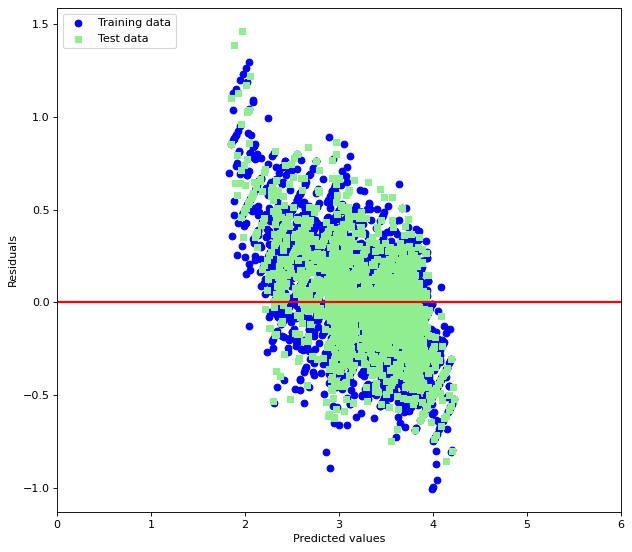

In [70]:
plt.figure(figsize=(8, 7), dpi=80)
plt.scatter(predict_train,  predict_train - target_train,
            c='blue', marker='o', label='Training data')
plt.scatter(predict_test,  predict_test - target_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([0, 6])
plt.tight_layout()

Потестим:

In [71]:
# user = int(input("Введите номер пользователя: "))
user = 100
fea, tar = choose_user(user)
users_movie = movies.query('movieId in @fea.index')
users_movie

,movieId,title,genres
839,1101,Top Gun (1986),Action|Romance
1005,1307,When Harry Met Sally... (1989),Comedy|Romance
1263,1678,"Joy Luck Club, The (1993)",Drama|Romance
1265,1680,Sliding Doors (1998),Drama|Romance
1319,1777,"Wedding Singer, The (1998)",Comedy|Romance
1394,1912,Out of Sight (1998),Comedy|Crime|Drama|Romance|Thriller
1435,1958,Terms of Endearment (1983),Comedy|Drama
1823,2423,Christmas Vacation (National Lampoon's Christm...,Comedy
3022,4041,"Officer and a Gentleman, An (1982)",Drama|Romance
3986,5620,Sweet Home Alabama (2002),Comedy|Romance


In [72]:
tasting_movies = return_recommend(fea)
tasting_movies

,movieId,title,genres
0,665,Underground (1995),Comedy|Drama|War
1,1518,Breakdown (1997),Action|Thriller
2,1357,Shine (1996),Drama|Romance
3,3865,"Original Kings of Comedy, The (2000)",Comedy|Documentary
4,4219,Girls Just Want to Have Fun (1985),Comedy
...,...,...,...
195,3055,Felicia's Journey (1999),Thriller
196,4628,New York Stories (1989),Comedy|Drama
197,2068,Fanny and Alexander (Fanny och Alexander) (1982),Drama|Fantasy|Mystery
198,1974,Friday the 13th (1980),Horror|Mystery|Thriller


Вот наша первая подборка из 200 фильмов, рекомендуемых для пользователя.

Идем дальше: вторым этапом создадим нейросеть, которая будет из этих 200 фильмов выбирать самые подходящие. Обучим ее независимо, а на тесте дадим ей датасет с 200 фильмами:

In [73]:
EMBEDDING_SIZE = 50

class RecommenderSys(keras.Model):    # используем класс, наследуемый от моделей keras
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderSys, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        # для юзера и для кинофильмов используем эмбеддинги
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # собираем всё, кроме биасов
        x = dot_user_movie + user_bias + movie_bias
        # и возвращаем вероятности - используем сигмоидную функцию активации
        return tf.nn.sigmoid(x)

model = RecommenderSys(len(ratings['userId'].unique()), len(ratings['movieId'].unique()), EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.0005)
)

Теперь для этого этапа оставим только юзеров и фильмы, что они смотрели, поскольку упор модели был на количество просмотревших фильм. Чем больше просмотрели - тем лучше фильм.  
При этом придется немного изменить датафрейм: поскольку айди юзеров и фильмов бывают не совсем с корректным числом цифр, мы пронумеруем их заново. отталкиваясь от числа уникальных значений айди фильмов и юзеров:

In [74]:
df = ratings.sample(frac=1, random_state=42)   # возьмем дубль фрейма

user_ids = df["userId"].unique().tolist()

# заново пронумеруем айди
user_encoded = {x: i for i, x in enumerate(user_ids)}
# userencoded2user = {i: x for i, x in enumerate(user_ids)}


# и то же самое для фильмов:
movie_ids = df["movieId"].unique().tolist()

movie_encoded = {x: i for i, x in enumerate(movie_ids)}
# movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

# заведем новые столбцы
df["user"] = df["userId"].map(user_encoded)
df["movie"] = df["movieId"].map(movie_encoded)

# присвоим х вновь образованные фичи
x = df[["user", "movie"]].values

# нормализуем значения, сделав интервал от 0 до 1:
min_rating = ratings["rating"].min()
max_rating = ratings["rating"].max()
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# пусть валидационный сет будет 15%:
train_indices = int(0.85 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

Теперь посмотрим, как обучается модель: 

In [75]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=15,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/15
1340/1340 [==============================] - 6s 4ms/step - loss: 0.6710 - val_loss: 0.6274
Epoch 2/15
1340/1340 [==============================] - 5s 4ms/step - loss: 0.6225 - val_loss: 0.6278
Epoch 3/15
1340/1340 [==============================] - 5s 3ms/step - loss: 0.6150 - val_loss: 0.6197
Epoch 4/15
1340/1340 [==============================] - 4s 3ms/step - loss: 0.6096 - val_loss: 0.6162
Epoch 5/15
1340/1340 [==============================] - 4s 3ms/step - loss: 0.6075 - val_loss: 0.6125
Epoch 6/15
1340/1340 [==============================] - 4s 3ms/step - loss: 0.6044 - val_loss: 0.6105
Epoch 7/15
1340/1340 [==============================] - 4s 3ms/step - loss: 0.6014 - val_loss: 0.6096
Epoch 8/15
1340/1340 [==============================] - 4s 3ms/step - loss: 0.5998 - val_loss: 0.6088
Epoch 9/15
1340/1340 [==============================] - 4s 3ms/step - loss: 0.5990 - val_loss: 0.6067
Epoch 10/15
1340/1340 [==============================] - 4s 3ms/step - loss: 0.596

Посмотрим на графике:

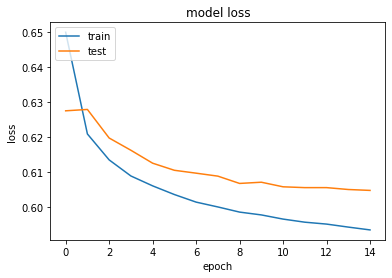

In [76]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Схождение довольно неплохое. Теперь попробуем запустить модель для предсказания фильмов для нашего испытуемого - юзера №100:

Напишем функцию, которая поможет адаптировать датафрейм для теста под конкретного пользователя:

In [77]:
def prepare_df(data_user, data_all):
    list_movies = data_user['movieId'].tolist()
    return data_all.query('movieId in @list_movies')

In [78]:
d = prepare_df(tasting_movies, df)

Вот и отобранные фильмы. Теперь предскажем, какие фильмы предположительно будет смотреть пользователь:

In [79]:
def recom_movies(data):
    rating = model.predict(data[["user", "movie"]]).flatten()
    data['ratings'] = rating
    max_rating = data["ratings"].sort_values(ascending=False)[:10].index.to_list()
    ratings_sort = data.query('index in @max_rating')
    id_movies = ratings_sort['movieId'].unique()
    final_data = movies.query('movieId in @id_movies')
    return final_data

In [80]:
recommendation_movies = recom_movies(d)
recommendation_movies

,movieId,title,genres
9,10,GoldenEye (1995),Action|Adventure|Thriller
275,316,Stargate (1994),Action|Adventure|Sci-Fi
307,349,Clear and Present Danger (1994),Action|Crime|Drama|Thriller
720,940,"Adventures of Robin Hood, The (1938)",Action|Adventure|Romance
946,1247,"Graduate, The (1967)",Comedy|Drama|Romance
1084,1408,"Last of the Mohicans, The (1992)",Action|Romance|War|Western
1961,2600,eXistenZ (1999),Action|Sci-Fi|Thriller
2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
4705,7022,Battle Royale (Batoru rowaiaru) (2000),Action|Drama|Horror|Thriller


И красиво оформляем на выходе:

In [81]:
print("Showing recommendations for user: {}".format(user))
print("====" * 10)
print("Movies with high ratings from user")
print("----" * 10)
users_movie[['title', 'genres']]

Showing recommendations for user: 100
Movies with high ratings from user
----------------------------------------


,title,genres
839,Top Gun (1986),Action|Romance
1005,When Harry Met Sally... (1989),Comedy|Romance
1263,"Joy Luck Club, The (1993)",Drama|Romance
1265,Sliding Doors (1998),Drama|Romance
1319,"Wedding Singer, The (1998)",Comedy|Romance
1394,Out of Sight (1998),Comedy|Crime|Drama|Romance|Thriller
1435,Terms of Endearment (1983),Comedy|Drama
1823,Christmas Vacation (National Lampoon's Christm...,Comedy
3022,"Officer and a Gentleman, An (1982)",Drama|Romance
3986,Sweet Home Alabama (2002),Comedy|Romance


In [82]:
print("Top movie recommendations")
print("----" * 10)
recommendation_movies[['title', 'genres']]

Top movie recommendations
----------------------------------------


,title,genres
9,GoldenEye (1995),Action|Adventure|Thriller
275,Stargate (1994),Action|Adventure|Sci-Fi
307,Clear and Present Danger (1994),Action|Crime|Drama|Thriller
720,"Adventures of Robin Hood, The (1938)",Action|Adventure|Romance
946,"Graduate, The (1967)",Comedy|Drama|Romance
1084,"Last of the Mohicans, The (1992)",Action|Romance|War|Western
1961,eXistenZ (1999),Action|Sci-Fi|Thriller
2355,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
4705,Battle Royale (Batoru rowaiaru) (2000),Action|Drama|Horror|Thriller


Всё работает. Осталось только немного оптимизировать: напишем функцию, которая будет запускать остаьные функции, принимая на вход id пользователя, а выдавать - фильм в топе юзера и рекомендации:

In [83]:
def finall_recom(number):
    fea, tar = choose_user(user)
    users_movie = movies.query('movieId in @fea.index')
    tasting_movies = return_recommend(fea)
    d = prepare_df(tasting_movies, df)
    recommendation_movies = recom_movies(d)
    print("Showing recommendations for user: {}".format(number))
    print("====" * 10)
    print("Movies with high ratings from user")
    print("----" * 10)
    print(tabulate(users_movie[['title', 'genres']]))
    print("----" * 10)
    print()
    print("Top movie recommendations")
    print("----" * 10)
    print(tabulate(recommendation_movies[['title', 'genres']]))

Потестим:

In [84]:
user = int(input("Введите номер пользователя: "))
finall_recom(user)

Введите номер пользователя: 45
Showing recommendations for user: 45
Movies with high ratings from user
----------------------------------------
----  -------------------------------------  ---------------------------------
1187  Contact (1997)                         Drama|Sci-Fi
1543  Jungle Book, The (1967)                Animation|Children|Comedy|Musical
1946  Go (1999)                              Comedy|Crime
1997  Rocky Horror Picture Show, The (1975)  Comedy|Horror|Musical|Sci-Fi
2022  Big Daddy (1999)                       Comedy
2674  Gladiator (2000)                       Action|Adventure|Drama
2779  Gone in 60 Seconds (2000)              Action|Crime
2808  Patriot, The (2000)                    Action|Drama|War
2836  X-Men (2000)                           Action|Adventure|Sci-Fi
2840  What Lies Beneath (2000)               Drama|Horror|Mystery
----  -------------------------------------  ---------------------------------
----------------------------------------

Top movie re

И еще раз:

In [85]:
user = int(input("Введите номер пользователя: "))
finall_recom(user)

Введите номер пользователя: 16
Showing recommendations for user: 16
Movies with high ratings from user
----------------------------------------
----  ---------------------------------------------------------------------------  --------------------------------
 474  Blade Runner (1982)                                                          Action|Sci-Fi|Thriller
 520  Fargo (1996)                                                                 Comedy|Crime|Drama|Thriller
 602  Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)  Comedy|War
 901  Brazil (1985)                                                                Fantasy|Sci-Fi
 923  Full Metal Jacket (1987)                                                     Drama|War
 951  Chinatown (1974)                                                             Crime|Film-Noir|Mystery|Thriller
3141  Memento (2000)                                                               Mystery|Thriller
3984  Spirited Away (S

В целом, если смотреть по жанрам, гибридная система действительно гораздо лучше рекомендует, чем отдельные модели из прошлых домашних заданий.

### Вывод

Цель данной работы - построить гибридную модель рекомендательной системы для подбора конкретному пользователю фильмов.  
Работа состояла из нескольких этапов:  
- На первом этапе мы анализировали данные, искали зависимости и предобрабатывали датасеты.  
- На втором этапе мы работали с текстовыми данными и объединяли таблицы в одну.  
- На этапе обучения моделей мы сделали выбор в пользу каскадного метода обучения.  
    - Для первого уровня обучения выбрали модель ближайших соседей. С ее помощью мы смогли выбрать топ-200 фильмов, которые предположительно могут понравиться юзеру. В качестве тестовой выборки использовали топ-10 фильмов пользователя (те, что он оценил выше всего). 
    - Далее независимо обучали класс нейросети, которому впоследствии "скармливали" таблицу с топ-200 фильмами. На основе данной таблицы нейросеть делала подборку из наиболее подходящих фильмов.  
    
По результату подбора ряда фильмов нескольким пользователям можно сделать вывод, что гибридная система действительно подбирает схожие по жанру, тегу и оценке фильмы, а также использует информацию о количестве юзеров, посмотревших фильм.    
Цель работы достигнута.